<div align="center">

# Lista 5

</div>

<div align="center" style="">

### Importy

</div>

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
import numpy as np

<div align="center" style="">

### Wczytanie danych oraz przerobienie ich

</div>

In [8]:
df = pd.read_csv('Titanic Dataset.csv')

df = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked']]

df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df['fare'] = df['fare'].fillna(df['fare'].median())

label_encoders = {}

for col in ['sex', 'embarked']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(columns=['survived'])
y = df['survived']

<div align="center" style="">

### Podzielenie danych na testowe i treningowe

</div>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

<div align="center" style="">

### Funkcje służące zmienające zmienne numeryczne na kategoryczne

</div>

In [10]:
from sklearn.cluster import KMeans

def fit_equal_width(X_train, k):
    bins = {}
    for col in ['age','sibsp','parch','fare']:
        _, edges = pd.cut(X_train[col], bins=k, retbins=True, duplicates='drop')
        bins[col] = edges
    return bins

def transform_equal_width(X, bins):
    Xq = X.copy()
    for col, edges in bins.items():
        Xq[col] = pd.cut(Xq[col], bins=edges, labels=False, include_lowest=True)
    return Xq

def fit_equal_freq(X_train, k):
    bins = {}
    for col in ['age','sibsp','parch','fare']:
        try:
            _, edges = pd.qcut(X_train[col], q=k, retbins=True, duplicates='drop')
        except ValueError:
            # za mało unikalnych wartości - fallback do cut
            _, edges = pd.cut(X_train[col], bins=k, retbins=True, duplicates='drop')
        bins[col] = edges
    return bins

def transform_equal_freq(X, bins):
    Xq = X.copy()
    for col, edges in bins.items():
        Xq[col] = pd.cut(Xq[col], bins=edges, labels=False, include_lowest=True)
    return Xq

def fit_kmeans(X_train, k):
    models = {}
    for col in ['age','sibsp','parch','fare']:
        km = KMeans(n_clusters=k, random_state=0)
        km.fit(X_train[[col]])
        models[col] = km
    return models

def transform_kmeans(X, models):
    Xq = X.copy()
    for col, km in models.items():
        Xq[col] = km.predict(X[[col]])
    return Xq


<div align="center" style="">

### Ewaluacja

</div>

In [11]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

def evaluate(method, k):
    fit_obj = method['fit'](X_train, k)
    X_train_q = method['transform'](X_train, fit_obj)
    X_test_q  = method['transform'](X_test, fit_obj)

    model = CategoricalNB()
    model.fit(X_train_q, y_train)
    y_pred = model.predict(X_test_q)

    return accuracy_score(y_test, y_pred)


dsdsa

In [13]:
methods = {
    "equal_width": {
        "fit": fit_equal_width,
        "transform": transform_equal_width
    },
    "equal_freq": {
        "fit": fit_equal_freq,
        "transform": transform_equal_freq
    },
    "kmeans": {
        "fit": fit_kmeans,
        "transform": transform_kmeans
    }
}

results = []

print(methods.items())

for method_name, method_funcs in methods.items():
    for k in [2, 5, 10, 25]:
        acc = evaluate(method_funcs, k)
        results.append([method_name, k, acc])

import pandas as pd
results_df = pd.DataFrame(results, columns=["method", "k", "accuracy"])
print(results_df)


dict_items([('equal_width', {'fit': <function fit_equal_width at 0x000002761098C720>, 'transform': <function transform_equal_width at 0x000002761098D940>}), ('equal_freq', {'fit': <function fit_equal_freq at 0x000002761098D3A0>, 'transform': <function transform_equal_freq at 0x000002761098E8E0>}), ('kmeans', {'fit': <function fit_kmeans at 0x000002761098EE80>, 'transform': <function transform_kmeans at 0x000002761098DEE0>})])
         method   k  accuracy
0   equal_width   2  0.729008
1   equal_width   5  0.729008
2   equal_width  10  0.740458
3   equal_width  25  0.706107
4    equal_freq   2  0.717557
5    equal_freq   5  0.717557
6    equal_freq  10  0.732824
7    equal_freq  25  0.721374
8        kmeans   2  0.717557
9        kmeans   5  0.736641
10       kmeans  10  0.725191
11       kmeans  25  0.725191


c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct 

<div align="center">

## Zadanie 2

</div>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def analyze_dataset(path):
    # Wczytaj macierz n x 2
    X = np.load(path)   # np.array o wymiarze (n, 2)

    # ---------- KMeans ----------
    kmeans = KMeans(n_clusters=3, random_state=0)
    labels_km = kmeans.fit_predict(X)

    # ---------- GMM ----------
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    labels_gmm = gmm.fit_predict(X)

    # ---------- Wizualizacja ----------
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(X[:,0], X[:,1], c=labels_km, s=20)
    axs[0].set_title("K-Means clustering")

    axs[1].scatter(X[:,0], X[:,1], c=labels_gmm, s=20)
    axs[1].set_title("Gaussian Mixture Model")

    plt.suptitle(path)
    plt.show()

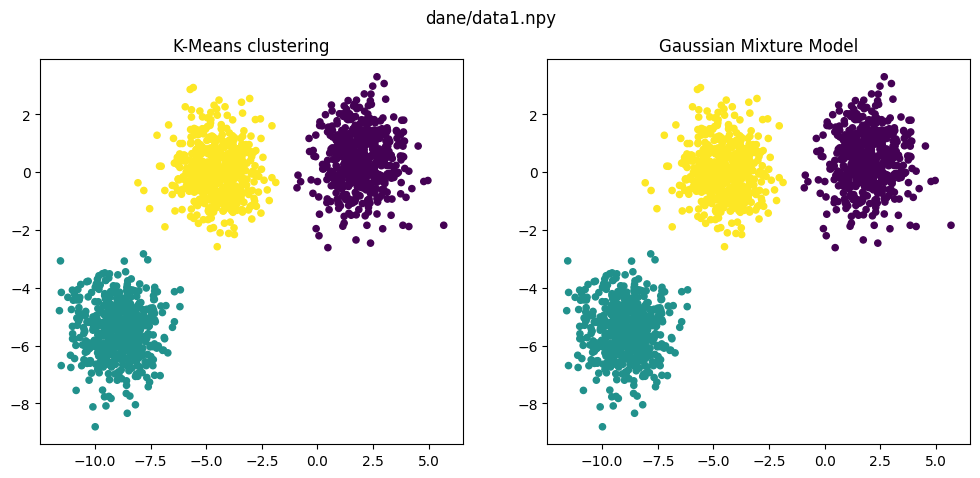

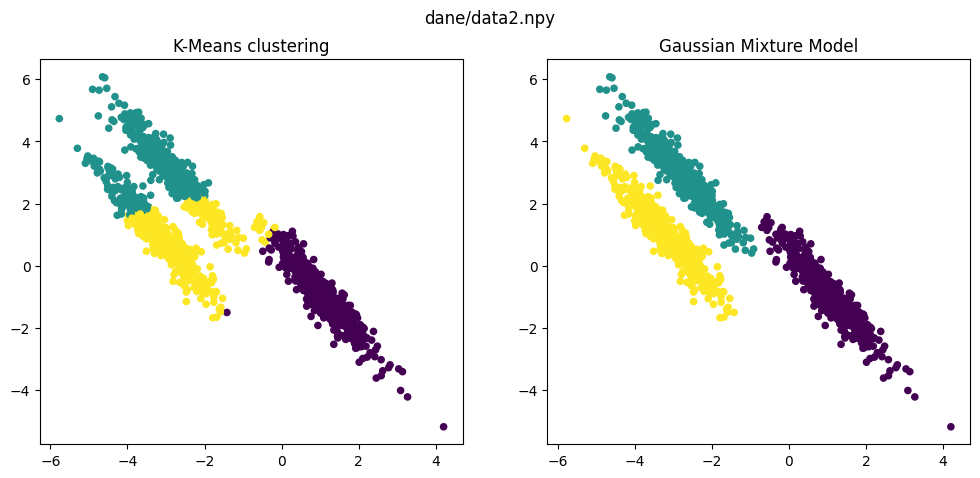

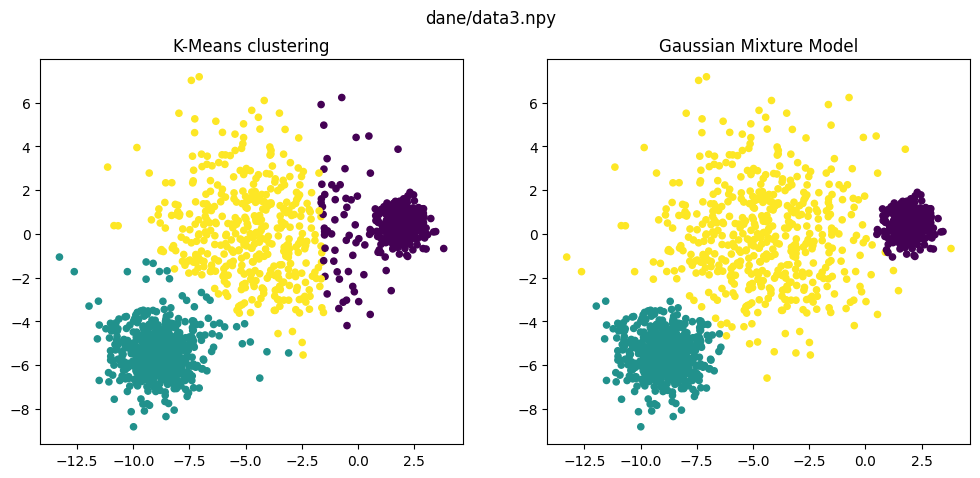

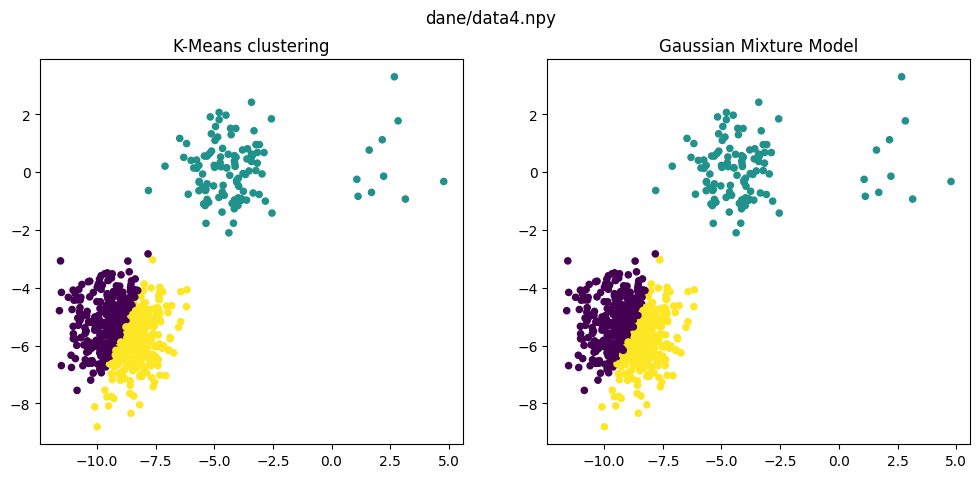

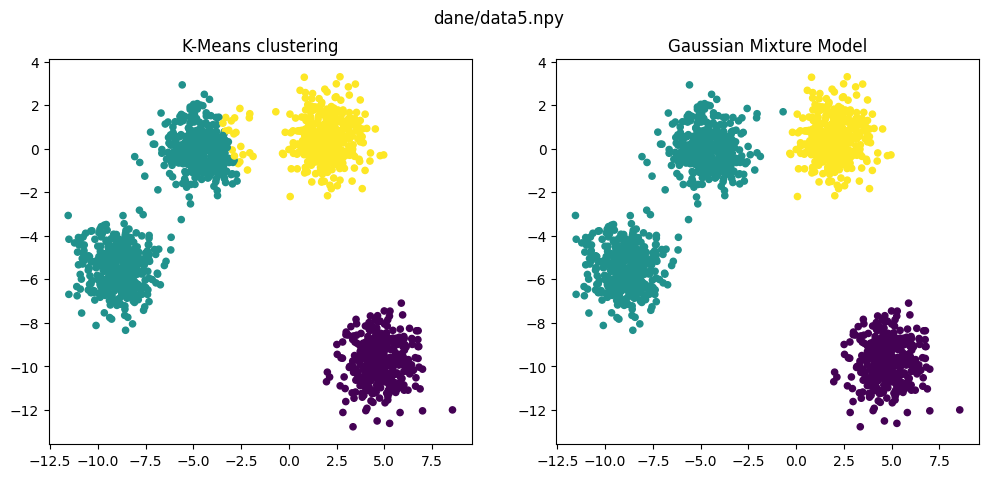

In [10]:
for i in range(1, 6):
    analyze_dataset(f"dane/data{i}.npy")


<div align="center">

## Zadanie 3

</div>

In [3]:
import numpy as np

images = np.load('dane/image_emb.npy')
images_lable = np.load('dane/image_labels.npy', allow_pickle=True)
images_test = np.load('dane/image_emb_test.npy')
images_labels_test = np.load('dane/image_labels_test.npy', allow_pickle=True)


labled_idx = np.where(images_lable != '')
mask = images_lable != ''
classes = np.unique(images_lable[images_lable != ''])


print(classes)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


# Tworzenie modelu

In [4]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from collections import Counter

kmeans = KMeans(n_clusters=len(classes), random_state=69)
clussters = kmeans.fit_predict(X=images)

def get_clusster_to_class(c, il):
    clusster_to_class = [Counter() for _ in range(len(classes))]

    for num, cls in zip(c, il):
        clusster_to_class[num][cls] += 1

    print(clusster_to_class)

    return {i: clusster_to_class[i].most_common()[0][0] for i in range(len(clusster_to_class))}


hash_map = get_clusster_to_class(clussters[labled_idx], images_lable[labled_idx])

res = [hash_map[c] for c in clussters]

test_clusters = kmeans.predict(X=images_test)
test_pred = [hash_map[c] for c in test_clusters]


acc = accuracy_score(images_labels_test, test_pred)

print("(K-MEANS) Accuracy:", acc)

# gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=69)
# clussters = gmm.fit_predict(X=images)

# hash_map = get_clusster_to_class(clussters[labled_idx], images_lable[labled_idx])

# res = [hash_map[c] for c in clussters]

# test_clusters = gmm.predict(X=images_test)
# test_pred = [hash_map[c] for c in test_clusters]


# acc = accuracy_score(images_labels_test, test_pred)

# print("(GMM) Accuracy:", acc)

[Counter({'airplane': 3, 'ship': 2, 'automobile': 1}), Counter({'deer': 5, 'cat': 1}), Counter({'ship': 3}), Counter({'airplane': 2}), Counter({'frog': 5}), Counter({'automobile': 4}), Counter({'horse': 5}), Counter({'dog': 5, 'cat': 4, 'bird': 1}), Counter({'truck': 5}), Counter({'bird': 4})]
(K-MEANS) Accuracy: 0.7513333333333333


<div align="center">

## Zadanie 4

</div>

In [51]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('pca', KernelPCA(n_components=100, random_state=42, kernel='rbf'))
])

pca_matrix = pipeline.fit_transform(newsgroups.data)
print("Shape:", pca_matrix.shape)

Shape: (11314, 100)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

scores = []
K = range(2, 21)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(pca_matrix)
    scores.append(silhouette_score(pca_matrix, labels))

for k, s in zip(K, scores):
    print(k, s)

[[-9.82092528e-05 -1.53910334e-04 -9.04233021e-05 ...  1.85734922e-04
   1.18517713e-04 -1.11805144e-04]
 [-2.14560373e-04 -1.12348180e-04  4.70974829e-05 ...  1.29368828e-04
  -5.78354281e-05 -2.43321436e-05]
 [ 1.13807001e-05  3.06527477e-05  1.14694380e-04 ... -1.76448043e-04
  -1.69137961e-04 -7.45914512e-05]
 ...
 [-1.57867974e-04  1.37096185e-04  1.07162495e-04 ...  1.40613151e-05
   5.26502445e-05 -3.07607841e-06]
 [-7.85049500e-05 -2.39947655e-05 -2.84836066e-05 ...  1.35162159e-04
   5.36418741e-05  2.04819473e-05]
 [-1.23380260e-04 -5.45958253e-05 -9.52367701e-05 ...  8.92478036e-05
  -1.08303108e-05  4.73531000e-05]]
2 0.16012745788150867
3 0.11323969899932135
4 0.11299401511122048
5 0.11462332158526871
6 0.016369156652841062
7 0.02113398404771461
8 0.01236512632293368
9 0.030132274152775165
10 0.03743323981079035
11 0.02151230978822523
12 0.031350827905445855
13 0.03409562239071335
14 0.02999551243554268
15 0.03458865445460943
16 0.0402700616026544
17 0.0430482765590477
18 

In [54]:
inertias = []

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(pca_matrix)
    inertias.append(model.inertia_)

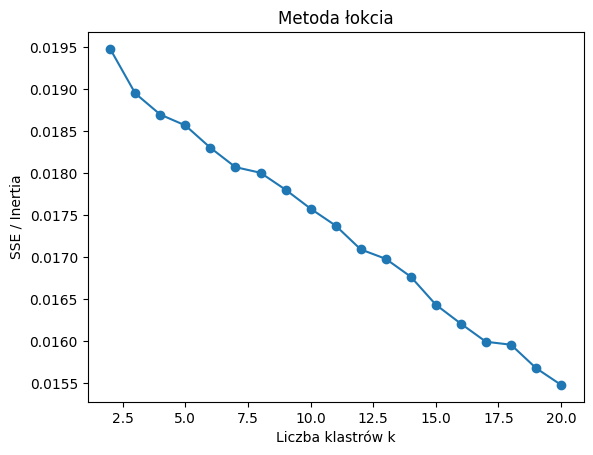

In [55]:
import matplotlib.pyplot as plt

plt.plot(K, inertias, 'o-')
plt.xlabel("Liczba klastrów k")
plt.ylabel("SSE / Inertia")
plt.title("Metoda łokcia")
plt.show()

In [56]:
k = 10
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(pca_matrix)

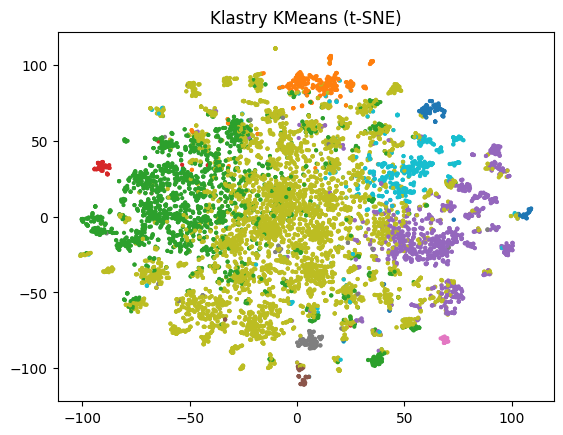

In [57]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
matrix_2d = tsne.fit_transform(pca_matrix)

plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=cluster_labels, cmap='tab10', s=4)
plt.title("Klastry KMeans (t-SNE)")
plt.show()


In [58]:
import numpy as np

for i in range(k):
    print(f"\n=== Klaster {i} ===")
    idx = np.where(cluster_labels == i)[0][:5]  # 5 przykładowych tekstów
    for j in idx:
        print(newsgroups.data[j][:200].replace("\n", " "), "...")


=== Klaster 0 ===
From: iisakkil@gamma.hut.fi (Mika Iisakkila) Subject: Re: what to do with old 256k SIMMs? In-Reply-To: rubin@cis.ohio-state.edu's message of 17 Apr 1993 14:05:06 -0400 Nntp-Posting-Host: gamma.hut.fi  ...
From: tchen@magnus.acs.ohio-state.edu (Tsung-Kun Chen) Subject: ** Software forsale (lots) ** Nntp-Posting-Host: magnusug.magnus.acs.ohio-state.edu Organization: The Ohio State University     ****   T ...
From: cramer@optilink.COM (Clayton Cramer) Subject: Re: New Study Out On Gay Percentage Organization: Optilink Corporation, Petaluma, CA Lines: 19  In article <C5L0v1.JCv@news.cso.uiuc.edu>, dans@uxa. ...
From: cramer@optilink.COM (Clayton Cramer) Subject: Re: New Study Out On Gay Percentage Organization: Optilink Corporation, Petaluma, CA Lines: 31  In article <1993Apr16.164638.27218@galileo.cc.roches ...
From: stamber@rainbow.ecn.purdue.edu (Kevin L. Stamber) Subject: Re: How difficult is it to get Penguin tickets? Organization: Purdue University Engineering Comp

<div align="center">

## Zadanie 5

</div>

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('pca', KernelPCA(n_components=100, random_state=42, kernel='rbf'))
])

pca_matrix = pipeline.fit_transform(newsgroups.data)
print("Shape:", pca_matrix.shape)

Shape: (11314, 100)


In [18]:
import numpy as np

def create_clusters(X, k):
    np.random.seed(30)
    clusters = {}

    # Wybieramy losowe punkty jako centra startowe
    indices = np.random.choice(X.shape[0], k, replace=False)

    for idx, chosen_idx in enumerate(indices):
        clusters[idx] = {
            'center': X[chosen_idx].copy(),
            'points': []
        }

    return clusters


def distance(p1, p2):
    return np.linalg.norm(p1 - p2)


def assign_clusters(X, clusters):
    # Reset punktów
    for i in clusters:
        clusters[i]['points'] = []

    # Przypisujemy każdy punkt do najbliższego centrum
    for x in X:
        distances = [distance(x, clusters[i]['center']) for i in clusters]
        best_cluster = np.argmin(distances)
        clusters[best_cluster]['points'].append(x)

    return clusters


def update_clusters(clusters):
    # Dla każdego klastra obliczamy nowe centrum
    for i in clusters:
        pts = np.array(clusters[i]['points'])
        if pts.shape[0] > 0:
            clusters[i]['center'] = pts.mean(axis=0)

        clusters[i]['points'] = []

    return clusters


def pred_cluster(X, clusters):
    predictions = []
    for x in X:
        distances = [distance(x, clusters[i]['center']) for i in clusters]
        best_cluster = np.argmin(distances)
        predictions.append(best_cluster)
    return predictions

k = 10
clusters = create_clusters(pca_matrix, k)

for it in range(1000):
    clusters = assign_clusters(pca_matrix, clusters)
    clusters = update_clusters(clusters)

labels = pred_cluster(pca_matrix, clusters)
print(set(labels))

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
matrix_2d = tsne.fit_transform(pca_matrix)

plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=labels, cmap='tab10', s=4)
plt.title("Klastry KMeans (t-SNE)")
plt.show()


KeyboardInterrupt: 

In [ ]:
import numpy as np

def create_clusters(X, k):
    np.random.seed(30)
    clusters = {}

    for idx in range(k):
        center = X[np.random.choice(X.shape[0])]
        points = []
        cluster = {
            'center': center,
            'points': points,
        }

        clusters[idx] = cluster

    return clusters

def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

def assign_clusters(X, clusters):
    for idx in range(X.shape[0]):
        dist = []
        
        curr_x = X[idx]
        
        for i in range(len(clusters)):
            dis = distance(curr_x, clusters[i]['center'])
            dist.append(dis)
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(curr_x)
    return clusters

def update_clusters(clusters):
    for i in range(len(clusters)):
        points = np.array(clusters[i]['points'])
        if points.shape[0] > 0:
            new_center = points.mean(axis =0)
            clusters[i]['center'] = new_center
            
            clusters[i]['points'] = []
    return clusters
        
def pred_cluster(X, clusters):
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(len(clusters)):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

In [ ]:
clusters = create_clusters(pca_matrix, K)
for it in range(10):
    clusters = assign_clusters(pca_matrix, clusters)
    clusters = update_clusters(clusters)



NameError: name 'pca_matrix' is not defined

In [ ]:
import numpy as np
K = 10

np.random.seed(23)
clusters = {}

for idx in range(K):
    center = 2 * (2 * np.random.random((pca_matrix.shape[1],)) - 1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
    
    clusters[idx] = cluster

print(clusters)


{0: {'center': array([ 0.06919154,  1.78785042,  1.06183904, -0.87041662, -1.11581855,
        0.74488834, -1.33144319, -0.43023013,  0.47220939, -0.35227962,
       -1.99014048,  1.53612873,  1.53979015, -0.79836124,  0.35832746,
        1.91370766,  1.38037529, -1.73969824, -0.82102214, -0.84826224,
        1.28986536,  0.50473215, -1.55808914, -1.99788476,  1.76866493,
       -1.43399697, -0.3136139 , -0.61404224,  1.47914034, -0.28559275,
        1.31500594,  0.87140735, -1.52309322,  0.38553669, -1.48097481,
       -1.68986363,  1.32482102, -0.14245754, -1.35195008,  0.19190117,
        0.35394329,  1.09445268,  0.62338183,  0.23082704, -1.28701093,
       -1.03766588,  0.02421853, -0.4130172 , -0.06777926,  1.82295936,
        1.60640877,  0.02303729,  1.28280594,  1.3108637 , -1.07266661,
       -1.68377805, -0.13694829,  1.51590323, -1.40998777, -1.07499478,
        1.67178322, -1.48374589,  1.66563089, -1.0608098 ,  0.46394707,
        1.80635104, -0.97947672, -0.19897941,  1.

In [ ]:
def distance(p, x):
    return np.sqrt(np.sum(p - x)**2)

In [ ]:
def assign_clusters(X, clusters):
    for idx in range(X.shape[0]):
        dist = []
        
        curr_x = X[idx]
        
        for i in range(K):
            dis = distance(curr_x,clusters[i]['center'])
            dist.append(dis)
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(curr_x)
    return clusters

def update_clusters(X, clusters):
    for i in range(K):
        points = np.array(clusters[i]['points'])
        if points.shape[0] > 0:
            new_center = points.mean(axis =0)
            clusters[i]['center'] = new_center
            
            clusters[i]['points'] = []
    return clusters

In [ ]:
def pred_cluster(X, clusters):
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(K):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

In [ ]:
clusters = assign_clusters(pca_matrix,clusters)
clusters = update_clusters(pca_matrix,clusters)
pred = pred_cluster(pca_matrix,clusters)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
matrix_2d = tsne.fit_transform(pca_matrix)
plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=cluster_labels)

print(pred)
print(np.where(pred != ''))

NameError: name 'cluster_labels' is not defined